# 06 - Temporal Analysis: Entropy Evolution Over Time

Analyze how project entropy and governance characteristics change over the project lifecycle.

**Goals:**
1. Track entropy evolution over commit history
2. Identify governance transition points
3. Analyze contributor churn and its effects
4. Predict sustainability based on temporal patterns

## Setup

In [1]:
import json
import sys
from pathlib import Path
from datetime import datetime, timedelta
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter

# Add src to path
sys.path.insert(0, '../src')
from analysis.entropy_calculation import EntropyCalculator

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11

# Initialize entropy calculator
entropy_calc = EntropyCalculator()

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load Project Data

In [2]:
# Load all collected project data
data_dir = Path("../data/raw")
projects = {}

for file_path in data_dir.glob("*_data.json"):
    with open(file_path, 'r') as f:
        data = json.load(f)
        repo_name = data['repository']['full_name']
        projects[repo_name] = data

print(f"Loaded {len(projects)} projects:")
for name, data in projects.items():
    commits = len(data.get('recent_commits', []))
    print(f"  - {name}: {commits} commits")

Loaded 94 projects:
  - BurntSushi/ripgrep: 156 commits
  - babel/babel: 462 commits
  - pandas-dev/pandas: 1033 commits
  - mafintosh/pump: 2 commits
  - pallets/flask: 88 commits
  - etcd-io/etcd: 1953 commits
  - vitejs/vite: 967 commits
  - benjaminp/six: 17 commits
  - pnggroup/libpng: 176 commits
  - neovim/neovim: 3344 commits
  - curl/curl: 3268 commits
  - psf/requests: 57 commits
  - envoyproxy/envoy: 2413 commits
  - rust-random/rand: 149 commits
  - nodejs/node: 0 commits
  - eslint/eslint: 671 commits
  - yaml/pyyaml: 1 commits
  - hashicorp/terraform: 1094 commits
  - pypa/pip: 754 commits
  - dtolnay/thiserror: 84 commits
  - sindresorhus/got: 89 commits
  - openstack/nova: 679 commits
  - debug-js/debug: 7 commits
  - uuidjs/uuid: 30 commits
  - scikit-learn/scikit-learn: 0 commits
  - eclipse-che/che: 89 commits
  - rust-lang/rust: 0 commits
  - vercel/ms: 26 commits
  - sirupsen/logrus: 28 commits
  - django/django: 0 commits
  - lukeed/kleur: 0 commits
  - helm/helm:

## 2. Temporal Entropy Calculation

Calculate entropy using sliding windows over commit history.

In [3]:
def parse_commit_date(date_str: str) -> datetime:
    """Parse commit date string to datetime."""
    try:
        return datetime.fromisoformat(date_str.replace('Z', '+00:00'))
    except:
        return None

def calculate_window_entropy(commits: list, window_days: int = 30) -> list:
    """
    Calculate entropy using sliding windows.
    
    Args:
        commits: List of commit dictionaries with 'date' and 'author'
        window_days: Size of sliding window in days
    
    Returns:
        List of (date, entropy, commit_count, unique_authors) tuples
    """
    if not commits:
        return []
    
    # Parse dates and filter valid commits
    dated_commits = []
    for c in commits:
        date = parse_commit_date(c.get('date', ''))
        if date and c.get('author'):
            dated_commits.append({'date': date, 'author': c['author']})
    
    if not dated_commits:
        return []
    
    # Sort by date
    dated_commits.sort(key=lambda x: x['date'])
    
    # Get date range
    start_date = dated_commits[0]['date']
    end_date = dated_commits[-1]['date']
    
    # Calculate entropy for each window
    results = []
    window = timedelta(days=window_days)
    step = timedelta(days=window_days // 4)  # 25% overlap
    
    current_start = start_date
    while current_start < end_date:
        current_end = current_start + window
        
        # Get commits in window
        window_commits = [
            c for c in dated_commits 
            if current_start <= c['date'] < current_end
        ]
        
        if len(window_commits) >= 5:  # Minimum commits for meaningful entropy
            # Count contributions per author
            author_counts = defaultdict(int)
            for c in window_commits:
                author_counts[c['author']] += 1
            
            # Calculate entropy
            counts = list(author_counts.values())
            total = sum(counts)
            probs = np.array(counts) / total
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            
            # Normalize by max possible entropy
            max_entropy = np.log2(len(counts))
            norm_entropy = entropy / max_entropy if max_entropy > 0 else 0
            
            # Top contributor dominance
            top_dominance = max(counts) / total * 100
            
            results.append({
                'date': current_start + window / 2,  # Window midpoint
                'entropy': entropy,
                'normalized_entropy': norm_entropy,
                'commit_count': len(window_commits),
                'unique_authors': len(author_counts),
                'top_dominance': top_dominance
            })
        
        current_start += step
    
    return results

print("✅ Temporal entropy functions defined")

✅ Temporal entropy functions defined


## 3. Calculate Temporal Metrics

In [4]:
# Calculate temporal entropy for all projects
temporal_data = {}

for repo_name, data in projects.items():
    commits = data.get('recent_commits', [])
    
    if len(commits) < 20:
        print(f"  ⚠️  {repo_name}: Insufficient commits ({len(commits)})")
        continue
    
    # Calculate with 30-day windows
    entropy_series = calculate_window_entropy(commits, window_days=30)
    
    if entropy_series:
        temporal_data[repo_name] = pd.DataFrame(entropy_series)
        print(f"  ✓ {repo_name}: {len(entropy_series)} data points")
    else:
        print(f"  ⚠️  {repo_name}: Could not calculate entropy series")

print(f"\n✅ Calculated temporal entropy for {len(temporal_data)} projects")

  ✓ BurntSushi/ripgrep: 29 data points
  ✓ babel/babel: 52 data points
  ✓ pandas-dev/pandas: 53 data points
  ⚠️  mafintosh/pump: Insufficient commits (2)
  ✓ pallets/flask: 26 data points
  ✓ etcd-io/etcd: 57 data points
  ✓ vitejs/vite: 52 data points
  ⚠️  benjaminp/six: Insufficient commits (17)
  ✓ pnggroup/libpng: 42 data points
  ✓ neovim/neovim: 63 data points
  ✓ curl/curl: 64 data points
  ✓ psf/requests: 26 data points
  ✓ envoyproxy/envoy: 56 data points
  ✓ rust-random/rand: 36 data points
  ⚠️  nodejs/node: Insufficient commits (0)
  ✓ eslint/eslint: 52 data points
  ⚠️  yaml/pyyaml: Insufficient commits (1)
  ✓ hashicorp/terraform: 54 data points
  ✓ pypa/pip: 60 data points
  ✓ dtolnay/thiserror: 18 data points
  ✓ sindresorhus/got: 12 data points
  ✓ openstack/nova: 65 data points
  ⚠️  debug-js/debug: Insufficient commits (7)
  ✓ uuidjs/uuid: 10 data points
  ⚠️  scikit-learn/scikit-learn: Insufficient commits (0)
  ✓ eclipse-che/che: 45 data points
  ⚠️  rust-lang/r

  ✓ grafana/grafana: 52 data points


  ✓ emacs-mirror/emacs: 78 data points


  ✓ zloirock/core-js: 56 data points
  ⚠️  chalk/chalk: Insufficient commits (10)
  ✓ rust-lang/regex: 11 data points
  ⚠️  juliangruber/isarray: Insufficient commits (8)
  ✓ serde-rs/json: 24 data points
  ✓ spf13/cobra: 13 data points
  ✓ certifi/python-certifi: 5 data points
  ⚠️  node-fetch/node-fetch: Insufficient commits (0)
  ✓ prometheus/prometheus: 65 data points
  ✓ opentofu/opentofu: 57 data points
  ✓ apache/kafka: 52 data points
  ✓ python-attrs/attrs: 39 data points
  ✓ apache/spark: 52 data points
  ✓ serde-rs/serde: 33 data points
  ✓ labstack/echo: 5 data points
  ⚠️  keleshev/schema: Insufficient commits (16)
  ⚠️  feross/safe-buffer: Insufficient commits (0)
  ✓ apache/airflow: 53 data points
  ✓ axios/axios: 48 data points
  ✓ apache/hadoop: 63 data points
  ✓ dtolnay/anyhow: 24 data points
  ✓ prettier/prettier: 52 data points
  ✓ python/cpython: 52 data points
  ✓ ohmyzsh/ohmyzsh: 49 data points
  ✓ npm/node-semver: 8 data points
  ✓ tokio-rs/tokio: 52 data point

## 4. Entropy Evolution Visualization

Generating individual temporal entropy evolution plots...


  ✓ Saved BurntSushi_ripgrep_entropy_evolution.png
  ✓ Saved babel_babel_entropy_evolution.png


  ✓ Saved pandas_dev_pandas_entropy_evolution.png
  ✓ Saved pallets_flask_entropy_evolution.png


  ✓ Saved etcd_io_etcd_entropy_evolution.png
  ✓ Saved vitejs_vite_entropy_evolution.png


  ✓ Saved pnggroup_libpng_entropy_evolution.png
  ✓ Saved neovim_neovim_entropy_evolution.png


  ✓ Saved curl_curl_entropy_evolution.png
  ✓ Saved psf_requests_entropy_evolution.png


  ✓ Saved envoyproxy_envoy_entropy_evolution.png


  ✓ Saved rust_random_rand_entropy_evolution.png


  ✓ Saved eslint_eslint_entropy_evolution.png
  ✓ Saved hashicorp_terraform_entropy_evolution.png


  ✓ Saved pypa_pip_entropy_evolution.png
  ✓ Saved dtolnay_thiserror_entropy_evolution.png


  ✓ Saved sindresorhus_got_entropy_evolution.png
  ✓ Saved openstack_nova_entropy_evolution.png


  ✓ Saved uuidjs_uuid_entropy_evolution.png
  ✓ Saved eclipse_che_che_entropy_evolution.png


  ✓ Saved vercel_ms_entropy_evolution.png
  ✓ Saved sirupsen_logrus_entropy_evolution.png


  ✓ Saved helm_helm_entropy_evolution.png


  ✓ Saved nicotine_plus_nicotine_plus_entropy_evolution.png
  ✓ Saved rack_rack_entropy_evolution.png


  ✓ Saved fish_shell_fish_shell_entropy_evolution.png
  ✓ Saved ansible_ansible_entropy_evolution.png


  ✓ Saved vim_vim_entropy_evolution.png
  ✓ Saved gin_gonic_gin_entropy_evolution.png


  ✓ Saved fastapi_fastapi_entropy_evolution.png
  ✓ Saved webpack_webpack_entropy_evolution.png


  ✓ Saved tj_commander.js_entropy_evolution.png


  ✓ Saved containerd_containerd_entropy_evolution.png
  ✓ Saved yargs_yargs_entropy_evolution.png


  ✓ Saved clap_rs_clap_entropy_evolution.png
  ✓ Saved tmux_tmux_entropy_evolution.png


  ✓ Saved sparklemotion_nokogiri_entropy_evolution.png
  ✓ Saved expressjs_express_entropy_evolution.png


  ✓ Saved pallets_click_entropy_evolution.png
  ✓ Saved ibrahimcesar_react_lite_youtube_embed_entropy_evolution.png


  ✓ Saved grafana_grafana_entropy_evolution.png


  ✓ Saved emacs_mirror_emacs_entropy_evolution.png
  ✓ Saved zloirock_core_js_entropy_evolution.png


  ✓ Saved rust_lang_regex_entropy_evolution.png
  ✓ Saved serde_rs_json_entropy_evolution.png


  ✓ Saved spf13_cobra_entropy_evolution.png
  ✓ Saved certifi_python_certifi_entropy_evolution.png


  ✓ Saved prometheus_prometheus_entropy_evolution.png
  ✓ Saved opentofu_opentofu_entropy_evolution.png


  ✓ Saved apache_kafka_entropy_evolution.png
  ✓ Saved python_attrs_attrs_entropy_evolution.png


  ✓ Saved apache_spark_entropy_evolution.png
  ✓ Saved serde_rs_serde_entropy_evolution.png


  ✓ Saved labstack_echo_entropy_evolution.png
  ✓ Saved apache_airflow_entropy_evolution.png


  ✓ Saved axios_axios_entropy_evolution.png


  ✓ Saved apache_hadoop_entropy_evolution.png
  ✓ Saved dtolnay_anyhow_entropy_evolution.png


  ✓ Saved prettier_prettier_entropy_evolution.png
  ✓ Saved python_cpython_entropy_evolution.png


  ✓ Saved ohmyzsh_ohmyzsh_entropy_evolution.png
  ✓ Saved npm_node_semver_entropy_evolution.png


  ✓ Saved tokio_rs_tokio_entropy_evolution.png
  ✓ Saved urllib3_urllib3_entropy_evolution.png


  ✓ Saved numpy_numpy_entropy_evolution.png
  ✓ Saved madler_zlib_entropy_evolution.png

✅ Saved 66 individual entropy evolution plots to ../docs/diagrams/temporal_entropy


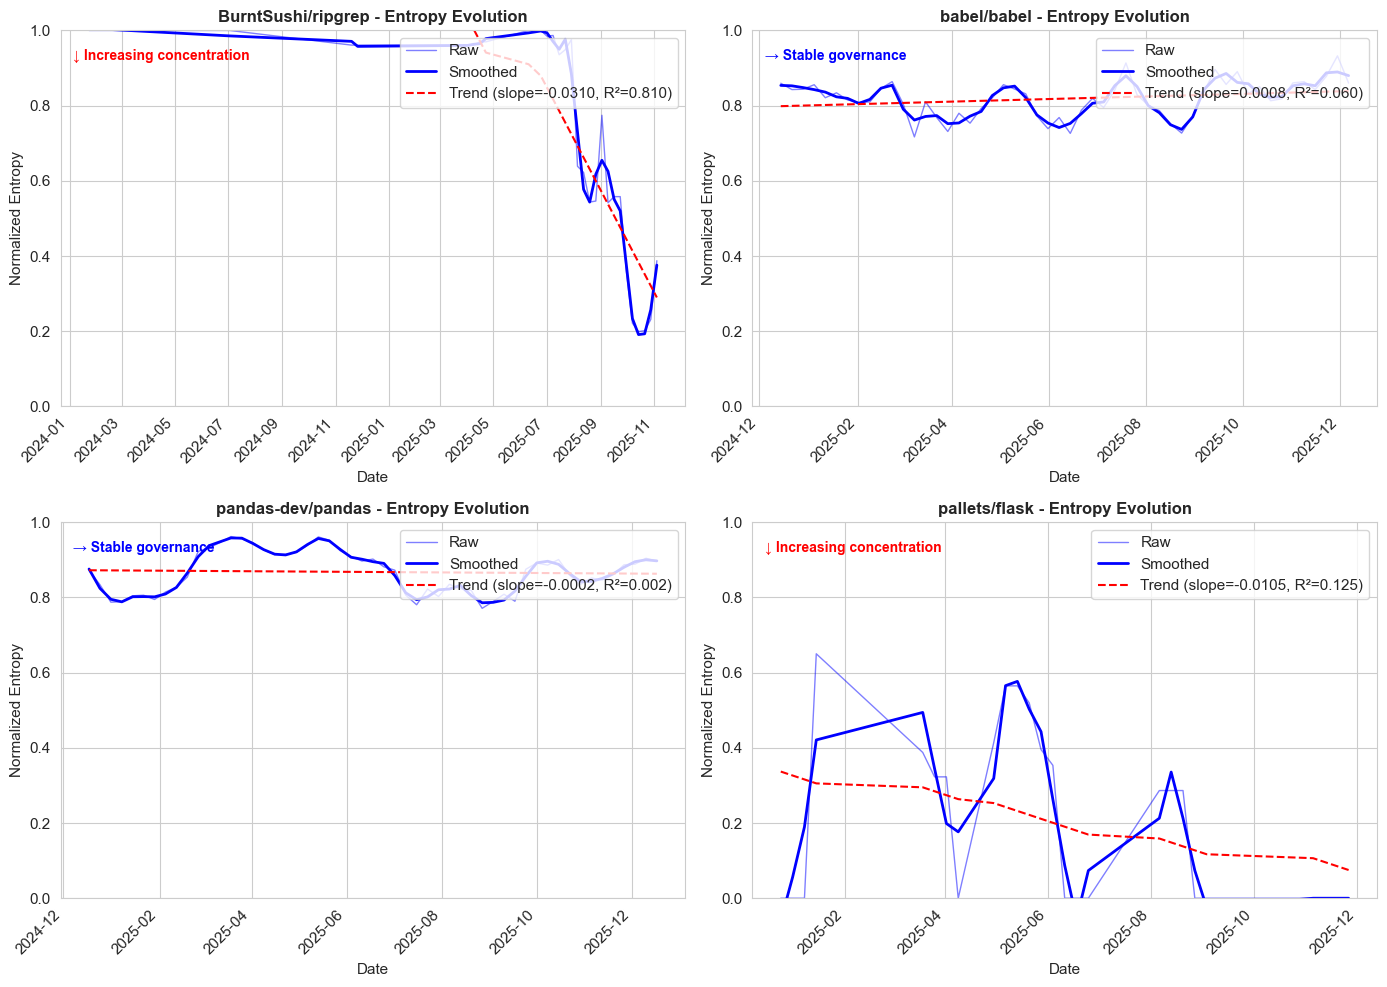


✅ Also saved temporal_entropy_sample.png (4 project preview)


In [5]:
def plot_entropy_evolution(df: pd.DataFrame, repo_name: str, ax=None, save_path=None):
    """
    Plot entropy evolution over time with trend analysis.
    
    Args:
        df: DataFrame with temporal entropy data
        repo_name: Repository name
        ax: Optional matplotlib axes
        save_path: Optional path to save individual figure
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
        standalone = True
    else:
        standalone = False
    
    # Convert dates
    dates = pd.to_datetime(df['date'])
    
    # Plot normalized entropy
    ax.plot(dates, df['normalized_entropy'], 'b-', alpha=0.5, linewidth=1, label='Raw')
    
    # Smoothed line
    if len(df) >= 5:
        window = min(5, len(df) // 2)
        if window >= 3:
            smoothed = savgol_filter(df['normalized_entropy'], window, 2)
            ax.plot(dates, smoothed, 'b-', linewidth=2, label='Smoothed')
    
    # Linear trend
    x_numeric = np.arange(len(df))
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        x_numeric, df['normalized_entropy']
    )
    trend_line = slope * x_numeric + intercept
    ax.plot(dates, trend_line, 'r--', linewidth=1.5, 
           label=f'Trend (slope={slope:.4f}, R²={r_value**2:.3f})')
    
    # Formatting
    ax.set_xlabel('Date')
    ax.set_ylabel('Normalized Entropy')
    ax.set_title(f'{repo_name} - Entropy Evolution', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add interpretation
    if slope > 0.01:
        interpretation = "↑ Increasing distribution"
        color = 'green'
    elif slope < -0.01:
        interpretation = "↓ Increasing concentration"
        color = 'red'
    else:
        interpretation = "→ Stable governance"
        color = 'blue'
    
    ax.text(0.02, 0.95, interpretation, transform=ax.transAxes, 
           fontsize=10, color=color, fontweight='bold', va='top')
    
    # Save individual file if path provided
    if standalone and save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    
    return ax

# Create output directory for individual plots
entropy_dir = Path('../docs/diagrams/temporal_entropy')
entropy_dir.mkdir(parents=True, exist_ok=True)

# Plot and save each project individually
if temporal_data:
    print("Generating individual temporal entropy evolution plots...")
    
    for repo_name, df in temporal_data.items():
        # Create safe filename from repo name
        safe_name = repo_name.replace('/', '_').replace('-', '_')
        save_path = entropy_dir / f'{safe_name}_entropy_evolution.png'
        
        plot_entropy_evolution(df, repo_name, save_path=save_path)
        print(f"  ✓ Saved {save_path.name}")
    
    print(f"\n✅ Saved {len(temporal_data)} individual entropy evolution plots to {entropy_dir}")
    
    # Also show a sample of 4 projects for quick review
    sample_projects = list(temporal_data.items())[:4]
    if sample_projects:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for ax, (repo_name, df) in zip(axes, sample_projects):
            plot_entropy_evolution(df, repo_name, ax)
        
        plt.tight_layout()
        plt.savefig('../docs/diagrams/temporal_entropy_sample.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n✅ Also saved temporal_entropy_sample.png (4 project preview)")
else:
    print("No temporal data to plot")

## 5. Contributor Activity Patterns

In [6]:
def analyze_contributor_activity(commits: list) -> pd.DataFrame:
    """
    Analyze temporal patterns of contributor activity.
    """
    if not commits:
        return pd.DataFrame()
    
    # Parse commits
    commit_data = []
    for c in commits:
        date = parse_commit_date(c.get('date', ''))
        if date and c.get('author'):
            commit_data.append({
                'date': date,
                'author': c['author'],
                'additions': c.get('additions', 0),
                'deletions': c.get('deletions', 0)
            })
    
    if not commit_data:
        return pd.DataFrame()
    
    df = pd.DataFrame(commit_data)
    df['month'] = df['date'].dt.to_period('M')
    
    # Calculate monthly statistics
    monthly = df.groupby('month').agg({
        'author': ['count', 'nunique'],
        'additions': 'sum',
        'deletions': 'sum'
    })
    monthly.columns = ['commits', 'unique_authors', 'additions', 'deletions']
    monthly['churn'] = monthly['additions'] + monthly['deletions']
    
    return monthly.reset_index()

# Analyze contributor activity
print("Contributor Activity Analysis:")
print("=" * 60)

for repo_name, data in projects.items():
    commits = data.get('recent_commits', [])
    monthly = analyze_contributor_activity(commits)
    
    if not monthly.empty:
        print(f"\n{repo_name}:")
        print(f"  Avg commits/month: {monthly['commits'].mean():.1f}")
        print(f"  Avg unique authors/month: {monthly['unique_authors'].mean():.1f}")
        print(f"  Max authors in a month: {monthly['unique_authors'].max()}")
        print(f"  Total code churn: {monthly['churn'].sum():,} lines")

Contributor Activity Analysis:

BurntSushi/ripgrep:
  Avg commits/month: 7.1
  Avg unique authors/month: 3.2
  Max authors in a month: 11
  Total code churn: 5,268 lines

babel/babel:
  Avg commits/month: 35.5
  Avg unique authors/month: 6.7
  Max authors in a month: 10
  Total code churn: 183,768 lines

pandas-dev/pandas:
  Avg commits/month: 79.5
  Avg unique authors/month: 36.9
  Max authors in a month: 89
  Total code churn: 81,456 lines

mafintosh/pump:
  Avg commits/month: 2.0
  Avg unique authors/month: 1.0
  Max authors in a month: 1
  Total code churn: 8 lines

pallets/flask:
  Avg commits/month: 8.8
  Avg unique authors/month: 2.0
  Max authors in a month: 5
  Total code churn: 21,292 lines

etcd-io/etcd:
  Avg commits/month: 114.9
  Avg unique authors/month: 14.2
  Max authors in a month: 25
  Total code churn: 177,504 lines

vitejs/vite:
  Avg commits/month: 74.4
  Avg unique authors/month: 22.7
  Max authors in a month: 32
  Total code churn: 123,700 lines

benjaminp/six:



apache/spark:
  Avg commits/month: 281.4
  Avg unique authors/month: 71.8
  Max authors in a month: 90
  Total code churn: 831,724 lines

serde-rs/serde:
  Avg commits/month: 16.6
  Avg unique authors/month: 2.3
  Max authors in a month: 4
  Total code churn: 24,636 lines

labstack/echo:
  Avg commits/month: 3.6
  Avg unique authors/month: 1.4
  Max authors in a month: 2
  Total code churn: 1,339 lines

keleshev/schema:
  Avg commits/month: 8.0
  Avg unique authors/month: 2.5
  Max authors in a month: 3
  Total code churn: 878 lines


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Ind


apache/airflow:
  Avg commits/month: 579.7
  Avg unique authors/month: 103.4
  Max authors in a month: 138
  Total code churn: 1,995,863 lines

axios/axios:
  Avg commits/month: 13.8
  Avg unique authors/month: 8.8
  Max authors in a month: 21
  Total code churn: 31,504 lines

apache/hadoop:
  Avg commits/month: 28.0
  Avg unique authors/month: 11.6
  Max authors in a month: 24
  Total code churn: 396,677 lines

dtolnay/anyhow:
  Avg commits/month: 5.1
  Avg unique authors/month: 1.2
  Max authors in a month: 2
  Total code churn: 960 lines

prettier/prettier:
  Avg commits/month: 81.8
  Avg unique authors/month: 9.8
  Max authors in a month: 17
  Total code churn: 347,984 lines

python/cpython:
  Avg commits/month: 364.8
  Avg unique authors/month: 112.0
  Max authors in a month: 176
  Total code churn: 780,227 lines

ohmyzsh/ohmyzsh:
  Avg commits/month: 16.6
  Avg unique authors/month: 12.2
  Max authors in a month: 20
  Total code churn: 5,175 lines

npm/node-semver:
  Avg commits

/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/754517742.py:24: UserWarning: Converting to PeriodArray/Ind

## 6. Governance Transition Detection

In [7]:
def detect_transitions(df: pd.DataFrame, threshold: float = 0.15) -> list:
    """
    Detect significant changes in entropy (potential governance transitions).
    
    Args:
        df: DataFrame with normalized_entropy column
        threshold: Minimum change to consider significant
    
    Returns:
        List of transition points with details
    """
    if len(df) < 3:
        return []
    
    transitions = []
    entropy = df['normalized_entropy'].values
    dates = pd.to_datetime(df['date'])
    
    # Calculate rolling differences
    for i in range(2, len(entropy)):
        # Compare to previous period
        prev_avg = np.mean(entropy[max(0, i-3):i])
        curr_avg = np.mean(entropy[i:min(len(entropy), i+3)])
        change = curr_avg - prev_avg
        
        if abs(change) >= threshold:
            transitions.append({
                'date': dates.iloc[i],
                'change': change,
                'direction': 'increasing' if change > 0 else 'decreasing',
                'before': prev_avg,
                'after': curr_avg,
                'interpretation': (
                    'Distribution increasing (toward Federation)' if change > 0
                    else 'Concentration increasing (toward Stadium)'
                )
            })
    
    return transitions

# Detect transitions for all projects
print("\nGovernance Transition Detection:")
print("=" * 60)

for repo_name, df in temporal_data.items():
    transitions = detect_transitions(df)
    
    print(f"\n{repo_name}:")
    if transitions:
        for t in transitions:
            print(f"  📌 {t['date'].strftime('%Y-%m')}: {t['interpretation']}")
            print(f"      Change: {t['before']:.3f} → {t['after']:.3f} ({t['change']:+.3f})")
    else:
        print(f"  No significant transitions detected")


Governance Transition Detection:

BurntSushi/ripgrep:
  📌 2025-07: Concentration increasing (toward Stadium)
      Change: 0.957 → 0.746 (-0.211)
  📌 2025-08: Concentration increasing (toward Stadium)
      Change: 0.953 → 0.602 (-0.352)
  📌 2025-08: Concentration increasing (toward Stadium)
      Change: 0.854 → 0.571 (-0.284)
  📌 2025-09: Concentration increasing (toward Stadium)
      Change: 0.625 → 0.379 (-0.245)
  📌 2025-09: Concentration increasing (toward Stadium)
      Change: 0.553 → 0.260 (-0.293)
  📌 2025-10: Concentration increasing (toward Stadium)
      Change: 0.492 → 0.207 (-0.284)
  📌 2025-10: Concentration increasing (toward Stadium)
      Change: 0.379 → 0.211 (-0.169)
  📌 2025-11: Distribution increasing (toward Federation)
      Change: 0.211 → 0.388 (+0.177)

babel/babel:
  No significant transitions detected

pandas-dev/pandas:
  No significant transitions detected

pallets/flask:
  📌 2025-01: Distribution increasing (toward Federation)
      Change: 0.000 → 0.

## 7. Bus Factor Temporal Analysis

Generating individual bus factor plots...


  ✓ Saved BurntSushi_ripgrep_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved babel_babel_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved pandas_dev_pandas_bus_factor.png


  ✓ Saved pallets_flask_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_3

  ✓ Saved etcd_io_etcd_bus_factor.png


  ✓ Saved vitejs_vite_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_3

/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved benjaminp_six_bus_factor.png
  ✓ Saved pnggroup_libpng_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight'

  ✓ Saved neovim_neovim_bus_factor.png
  ✓ Saved curl_curl_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_3

/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved psf_requests_bus_factor.png
  ✓ Saved envoyproxy_envoy_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved rust_random_rand_bus_factor.png
  ✓ Saved eslint_eslint_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved hashicorp_terraform_bus_factor.png
  ✓ Saved pypa_pip_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_3

/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight'

  ✓ Saved dtolnay_thiserror_bus_factor.png
  ✓ Saved sindresorhus_got_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_3

  ✓ Saved openstack_nova_bus_factor.png
  ✓ Saved uuidjs_uuid_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight'

  ✓ Saved eclipse_che_che_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved vercel_ms_bus_factor.png
  ✓ Saved sirupsen_logrus_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')

  ✓ Saved helm_helm_bus_factor.png
  ✓ Saved nicotine_plus_nicotine_plus_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved rack_rack_bus_factor.png
  ✓ Saved fish_shell_fish_shell_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved fatih_color_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved ansible_ansible_bus_factor.png
  ✓ Saved tartley_colorama_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved vim_vim_bus_factor.png
  ✓ Saved gin_gonic_gin_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight'

  ✓ Saved fastapi_fastapi_bus_factor.png
  ✓ Saved webpack_webpack_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved tj_commander.js_bus_factor.png
  ✓ Saved containerd_containerd_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')

  ✓ Saved lodash_lodash_bus_factor.png
  ✓ Saved yargs_yargs_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight'

  ✓ Saved clap_rs_clap_bus_factor.png
  ✓ Saved tmux_tmux_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_3

  ✓ Saved sparklemotion_nokogiri_bus_factor.png
  ✓ Saved expressjs_express_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight'

  ✓ Saved pallets_click_bus_factor.png
  ✓ Saved ibrahimcesar_react_lite_youtube_embed_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved grafana_grafana_bus_factor.png
  ✓ Saved emacs_mirror_emacs_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved zloirock_core_js_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved rust_lang_regex_bus_factor.png
  ✓ Saved serde_rs_json_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')

  ✓ Saved spf13_cobra_bus_factor.png
  ✓ Saved certifi_python_certifi_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved prometheus_prometheus_bus_factor.png
  ✓ Saved opentofu_opentofu_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved apache_kafka_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved python_attrs_attrs_bus_factor.png
  ✓ Saved apache_spark_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')

  ✓ Saved serde_rs_serde_bus_factor.png
  ✓ Saved labstack_echo_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved apache_airflow_bus_factor.png
  ✓ Saved axios_axios_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved apache_hadoop_bus_factor.png
  ✓ Saved dtolnay_anyhow_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_3

  ✓ Saved prettier_prettier_bus_factor.png
  ✓ Saved python_cpython_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')

  ✓ Saved ohmyzsh_ohmyzsh_bus_factor.png
  ✓ Saved npm_node_semver_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


  ✓ Saved tokio_rs_tokio_bus_factor.png
  ✓ Saved urllib3_urllib3_bus_factor.png


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


  ✓ Saved numpy_numpy_bus_factor.png
  ✓ Saved madler_zlib_bus_factor.png

✅ Saved 70 individual bus factor plots to ../docs/diagrams/bus_factor


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:108: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:109: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:151: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('../docs/diagrams/bus_factor_sample.png', dpi=150, bbox_inches='tight')
/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_74155/3759615203.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('../docs/diagrams/bus_factor_sample.png', dpi=150, bbo

/Users/ibrahimcesar/Dev/categories-of-the-commons/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ibrahimcesar/Dev/categories-of-the-commons/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ibrahimcesar/Dev/categories-of-the-commons/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


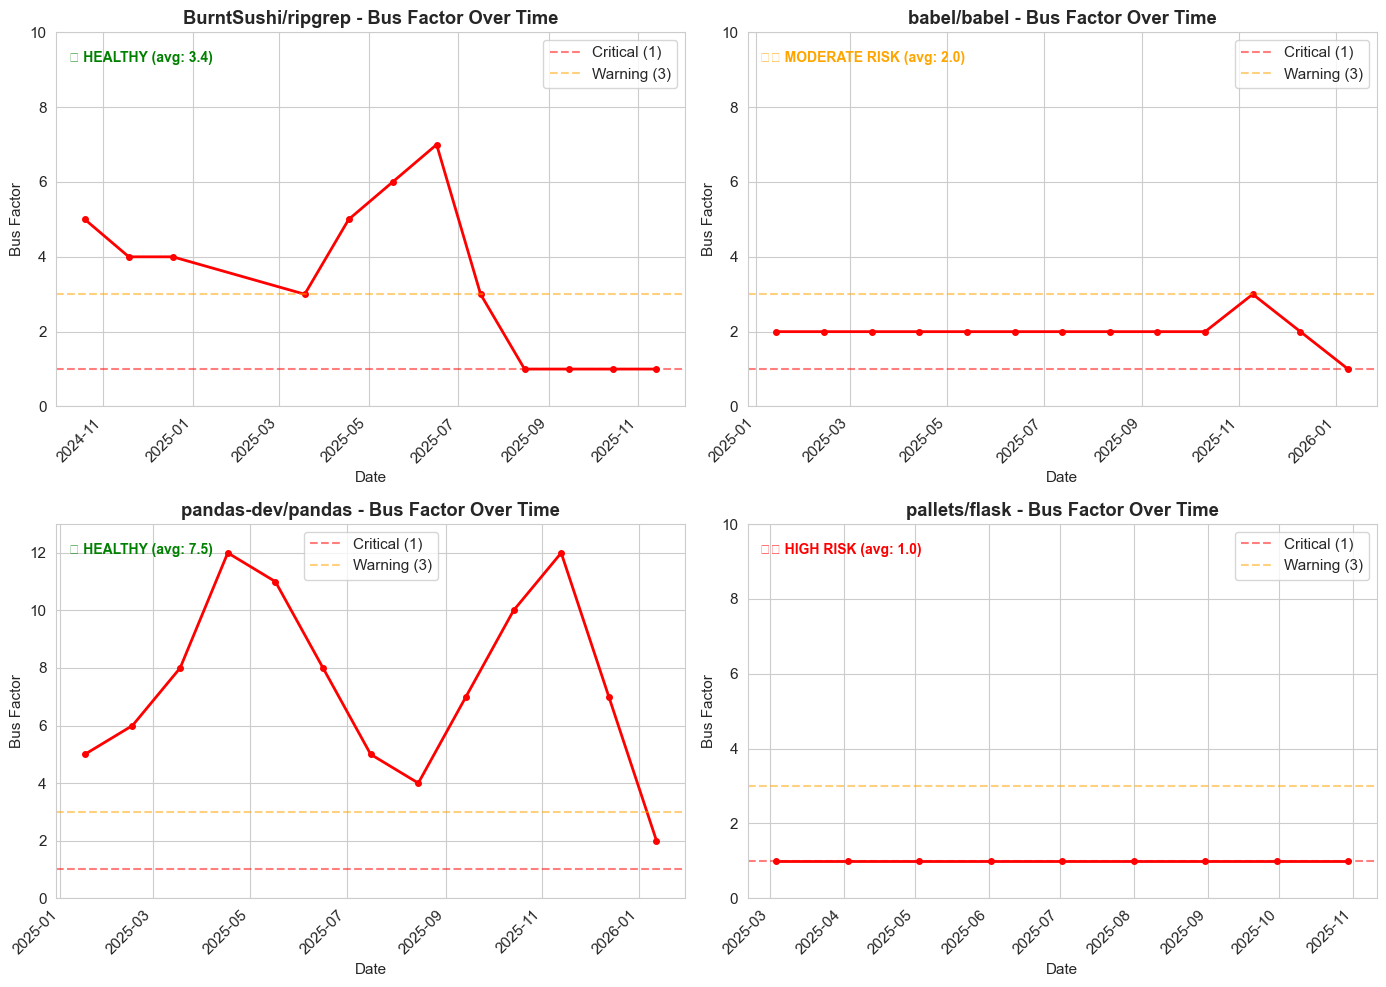


✅ Also saved bus_factor_sample.png (4 project preview)


In [8]:
def calculate_bus_factor_over_time(commits: list, window_days: int = 90) -> list:
    """
    Calculate bus factor (minimum contributors for 50% of commits) over time.
    """
    if not commits:
        return []
    
    # Parse commits
    dated_commits = []
    for c in commits:
        date = parse_commit_date(c.get('date', ''))
        if date and c.get('author'):
            dated_commits.append({'date': date, 'author': c['author']})
    
    if not dated_commits:
        return []
    
    dated_commits.sort(key=lambda x: x['date'])
    
    results = []
    window = timedelta(days=window_days)
    step = timedelta(days=window_days // 3)
    
    start_date = dated_commits[0]['date']
    end_date = dated_commits[-1]['date']
    
    current = start_date
    while current < end_date:
        window_end = current + window
        window_commits = [c for c in dated_commits if current <= c['date'] < window_end]
        
        if len(window_commits) >= 10:
            # Count contributions
            author_counts = defaultdict(int)
            for c in window_commits:
                author_counts[c['author']] += 1
            
            # Sort by contributions
            sorted_authors = sorted(author_counts.values(), reverse=True)
            total = sum(sorted_authors)
            
            # Calculate bus factor (contributors for 50%)
            cumsum = 0
            bus_factor = 0
            for count in sorted_authors:
                cumsum += count
                bus_factor += 1
                if cumsum >= total * 0.5:
                    break
            
            results.append({
                'date': current + window / 2,
                'bus_factor': bus_factor,
                'total_contributors': len(author_counts),
                'top_contributor_pct': sorted_authors[0] / total * 100
            })
        
        current += step
    
    return results

def plot_bus_factor(df: pd.DataFrame, repo_name: str, ax=None, save_path=None):
    """
    Plot bus factor over time for a single project.
    
    Args:
        df: DataFrame with bus factor data
        repo_name: Repository name
        ax: Optional matplotlib axes
        save_path: Optional path to save individual figure
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
        standalone = True
    else:
        standalone = False
    
    dates = pd.to_datetime(df['date'])
    
    ax.plot(dates, df['bus_factor'], 'r-', linewidth=2, marker='o', markersize=4)
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Critical (1)')
    ax.axhline(y=3, color='orange', linestyle='--', alpha=0.5, label='Warning (3)')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Bus Factor')
    ax.set_title(f'{repo_name} - Bus Factor Over Time', fontweight='bold')
    ax.set_ylim(0, max(10, df['bus_factor'].max() + 1))
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add risk assessment
    avg_bf = df['bus_factor'].mean()
    if avg_bf < 2:
        risk = "⚠️ HIGH RISK"
        risk_color = 'red'
    elif avg_bf < 3:
        risk = "⚠️ MODERATE RISK"
        risk_color = 'orange'
    else:
        risk = "✓ HEALTHY"
        risk_color = 'green'
    
    ax.text(0.02, 0.95, f'{risk} (avg: {avg_bf:.1f})', transform=ax.transAxes, 
           fontsize=10, color=risk_color, fontweight='bold', va='top')
    
    if standalone and save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    
    return ax

# Calculate bus factor over time
bus_factor_data = {}

for repo_name, data in projects.items():
    commits = data.get('recent_commits', [])
    bf_series = calculate_bus_factor_over_time(commits)
    
    if bf_series:
        bus_factor_data[repo_name] = pd.DataFrame(bf_series)

# Create output directory for individual plots
bf_dir = Path('../docs/diagrams/bus_factor')
bf_dir.mkdir(parents=True, exist_ok=True)

# Plot and save each project individually
if bus_factor_data:
    print("Generating individual bus factor plots...")
    
    for repo_name, df in bus_factor_data.items():
        # Create safe filename from repo name
        safe_name = repo_name.replace('/', '_').replace('-', '_')
        save_path = bf_dir / f'{safe_name}_bus_factor.png'
        
        plot_bus_factor(df, repo_name, save_path=save_path)
        print(f"  ✓ Saved {save_path.name}")
    
    print(f"\n✅ Saved {len(bus_factor_data)} individual bus factor plots to {bf_dir}")
    
    # Also show a sample of 4 projects for quick review
    sample_projects = list(bus_factor_data.items())[:4]
    if sample_projects:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for ax, (repo_name, df) in zip(axes, sample_projects):
            plot_bus_factor(df, repo_name, ax)
        
        plt.tight_layout()
        plt.savefig('../docs/diagrams/bus_factor_sample.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n✅ Also saved bus_factor_sample.png (4 project preview)")
else:
    print("No bus factor data to plot")

## 8. Summary Statistics

In [9]:
# Generate temporal summary
summary_data = []

for repo_name in temporal_data:
    df = temporal_data[repo_name]
    
    # Trend analysis
    x = np.arange(len(df))
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        x, df['normalized_entropy']
    )
    
    # Bus factor stats
    bf_df = bus_factor_data.get(repo_name)
    avg_bus_factor = bf_df['bus_factor'].mean() if bf_df is not None else None
    
    summary_data.append({
        'repository': repo_name,
        'mean_entropy': df['normalized_entropy'].mean(),
        'std_entropy': df['normalized_entropy'].std(),
        'trend_slope': slope,
        'trend_r2': r_value ** 2,
        'trend_significant': p_value < 0.05,
        'avg_bus_factor': avg_bus_factor,
        'trend_direction': 'Federating' if slope > 0.001 else ('Concentrating' if slope < -0.001 else 'Stable')
    })

df_summary = pd.DataFrame(summary_data)

print("\n" + "=" * 70)
print("TEMPORAL ANALYSIS SUMMARY")
print("=" * 70)
display(df_summary.round(4))

# Save results
output_path = Path('../data/processed/temporal_analysis.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)
df_summary.to_csv(output_path, index=False)
print(f"\n✅ Summary saved to {output_path}")


TEMPORAL ANALYSIS SUMMARY


,repository,mean_entropy,std_entropy,trend_slope,trend_r2,trend_significant,avg_bus_factor,trend_direction
0,BurntSushi/ripgrep,0.7241,0.2933,-0.0310,0.8104,True,3.4167,Concentrating
1,babel/babel,0.8187,0.0486,0.0008,0.0602,False,2.0000,Stable
2,pandas-dev/pandas,0.8676,0.0557,-0.0002,0.0024,False,7.4615,Stable
3,pallets/flask,0.2059,0.2267,-0.0105,0.1248,False,1.0000,Concentrating
4,etcd-io/etcd,0.7469,0.0668,0.0011,0.0773,True,2.4000,Federating
...,...,...,...,...,...,...,...,...
61,npm/node-semver,0.8804,0.1091,-0.0409,0.8433,True,1.5000,Concentrating
62,tokio-rs/tokio,0.8754,0.0806,-0.0014,0.0739,False,4.6667,Concentrating
63,urllib3/urllib3,0.8646,0.0691,0.0002,0.0011,False,1.8182,Stable
64,numpy/numpy,0.7821,0.0631,-0.0003,0.0082,False,4.3333,Stable



✅ Summary saved to ../data/processed/temporal_analysis.csv


## Key Findings

**Interpretation:**
- **Positive slope**: Project is "federating" - contributions becoming more distributed
- **Negative slope**: Project is "concentrating" - moving toward Stadium pattern
- **Low bus factor + negative slope**: High sustainability risk
- **Significant transitions**: May indicate key contributor departures or onboarding

**Next Steps:**
1. Correlate transitions with external events (releases, security issues)
2. Compare temporal patterns across project categories
3. Build predictive model for sustainability risk